In [1]:
import json
from types import SimpleNamespace

import torch

import numpy as np
import ot
from matplotlib import pyplot as plt
%matplotlib inline

from utils.solvers import FISTA
from model.lista import VIEncoderLISTA, LISTA
from model.vi_encoder import VIEncoder

[]

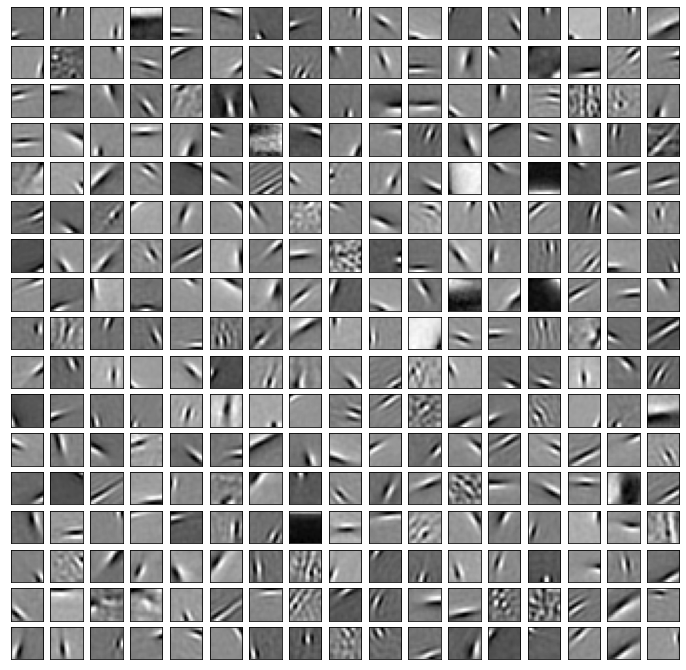

In [2]:
phi = np.load("data/ground_truth_dict.npy")

num_dictionaries = phi.shape[1]
patch_size = int(np.sqrt(phi.shape[0]))
fig = plt.figure(figsize=(12, 12))
for i in range(num_dictionaries):
    plt.subplot(int(np.sqrt(num_dictionaries)), int(np.sqrt(num_dictionaries)), i + 1)
    dict_element = phi[:, i].reshape(patch_size, patch_size)
    plt.imshow(dict_element, cmap='gray')
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

In [26]:
def compute_emd_act(base_coeff, perturb_coeff, phi, gamma=1e-1):
    emd = 0
    for i in range(num_examples):
        base_support = np.nonzero(base_coeff[i])[0]
        perturb_support = np.nonzero(perturb_coeff[i])[0]
        base_act = phi[:, base_support] * base_coeff[i, base_support]
        perturb_act = phi[:, perturb_support] * perturb_coeff[i, perturb_support]

        cost = ((base_act[:, :, None] - perturb_act[:, None, :])**2).sum(axis=0)
        base_uni = np.ones(len(base_support)) / len(base_support)
        perturb_uni = np.ones(len(perturb_support)) / len(perturb_support)
        transport_plan = ot.emd(base_uni, perturb_uni, cost)#, gamma)
        emd += (transport_plan * cost).sum() / num_examples
    print(cost.shape)
    return emd

In [28]:
epoch_load_list = ["0", "10", "50", "100", "200", "299"]
supp_diff = [0, 1, 10, 20]#, 1, 5, 20]
base_file = "results/VI_gaussian_synthetic/"
method = []
total_supp = 40
num_examples = 500

with open(base_file + "config.json") as json_data:
    config_data = json.load(json_data)
train_args = SimpleNamespace(**config_data['train'])
solver_args = SimpleNamespace(**config_data['solver'])

for diff in supp_diff:
    print(f"Support difference: {diff}")
    base_code = np.zeros((num_examples, phi.shape[1]))
    perturb_code = np.zeros((num_examples, phi.shape[1]))

    supp_count = total_supp + diff
    support = np.random.randint(0, high=phi.shape[1], size=(num_examples, supp_count))
    for i in range(num_examples):
        coeff_value = np.random.randn(total_supp + diff)
        base_code[i, support[i, :total_supp]] = coeff_value[:total_supp]
        perturb_code[i, support[i, diff:]] = coeff_value[diff:]

    base_image = base_code @ phi.T
    perturb_image = perturb_code @ phi.T
    gt_emd = compute_emd_act(base_code, perturb_code, phi)
    gt_l1 = np.abs(base_code - perturb_code).sum(axis=-1).mean()
    print(f"Base emd: {gt_emd:.3E}, L1 diff: {gt_l1:.3E}")

    base_est = FISTA(phi, base_image.T, tau=0.3).T
    perturb_est = FISTA(phi, perturb_image.T, tau=0.3).T
    fista_emd = compute_emd_act(base_est, perturb_est, phi)
    fista_l1 = np.abs(base_est - perturb_est).sum(axis=-1).mean()
    print(f"FISTA emd: {fista_emd:.2E}, L1 diff: {fista_l1:.3E}")

    for idx, method in enumerate(epoch_load_list):
        if method == 'FISTA':
            continue
        encoder = VIEncoder(train_args.patch_size, train_args.dict_size, solver_args).to('cuda:1')
        encoder.load_state_dict(torch.load(base_file + f"/encoderstate_epoch{method}.pt")['model_state'])
        
        dict_cu = torch.tensor(phi, device='cuda:1').float()
        base_cu = torch.tensor(base_image).float().to('cuda:1')
        perturb_cu = torch.tensor(perturb_image).float().to('cuda:1')
        iwae_loss, recon_loss, kl_loss, base_b = encoder(base_cu, dict_cu)
        iwae_loss, recon_loss, kl_loss, perturb_b = encoder(perturb_cu, dict_cu)
        vsc_emd = compute_emd_act(base_b.detach().cpu().numpy(), perturb_b.detach().cpu().numpy(), phi)
        vsc_l1 = torch.abs(base_b - perturb_b).sum(dim=-1).mean()
        print(f"{method} emd: {vsc_emd:.2E}, L1 diff: {vsc_l1:.3E}")
    print()


Support difference: 0
(38, 38)
Base emd: 0.000E+00, L1 diff: 0.000E+00
(33, 33)
FISTA emd: 0.00E+00, L1 diff: 0.000E+00
(182, 172)
0 emd: 9.01E-01, L1 diff: 1.974E+02
(132, 129)
10 emd: 3.05E-01, L1 diff: 7.685E+01
(64, 44)
50 emd: 6.63E-02, L1 diff: 1.246E+01
(63, 54)
100 emd: 8.04E-02, L1 diff: 1.650E+01
(51, 61)
200 emd: 8.25E-02, L1 diff: 1.793E+01


FileNotFoundError: [Errno 2] No such file or directory: 'results/VI_gaussian_synthetic//encoderstate_epoch300.pt'

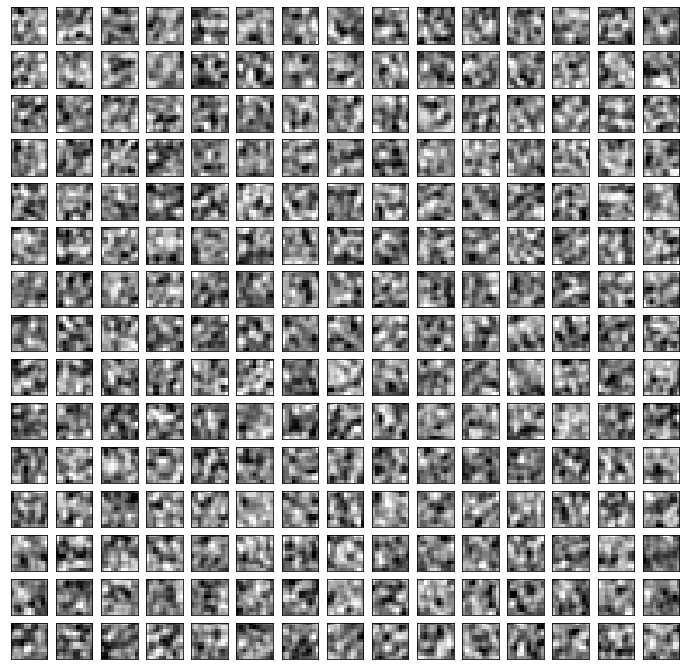

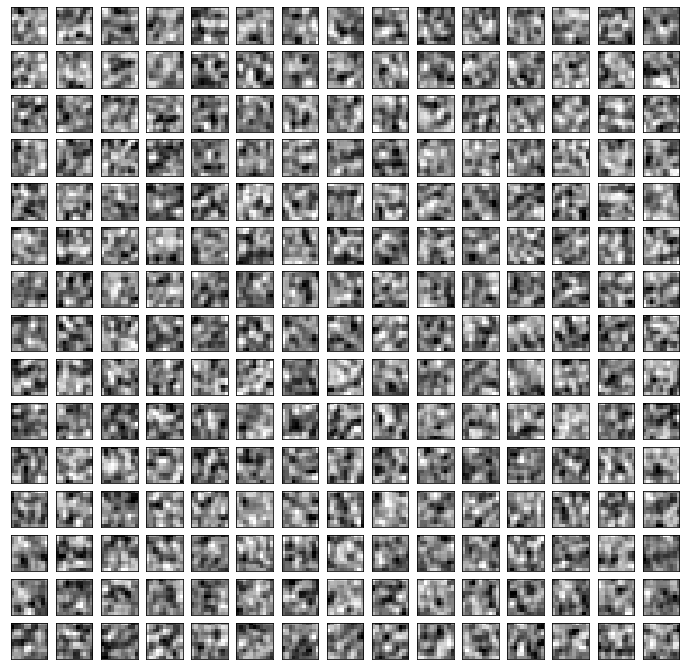

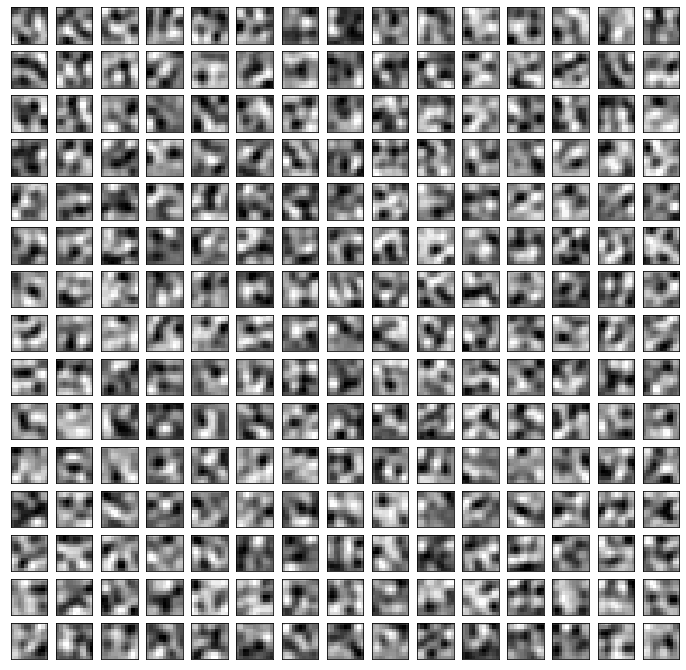

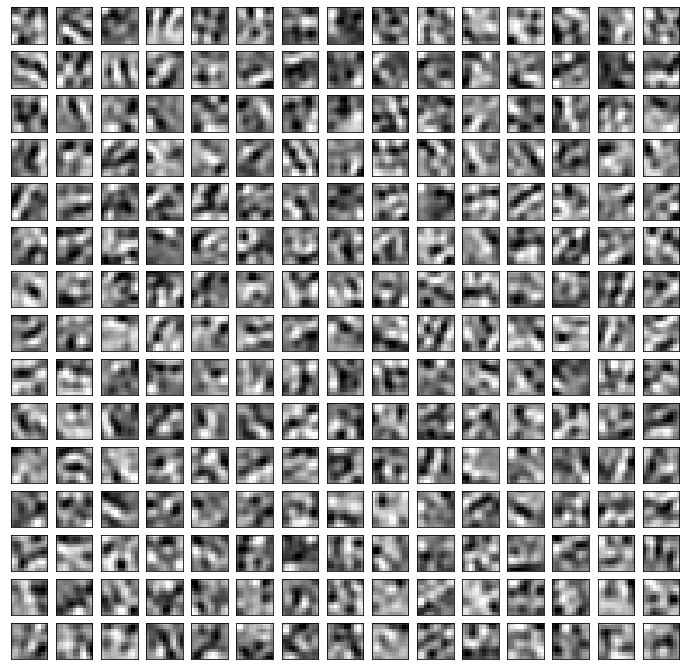

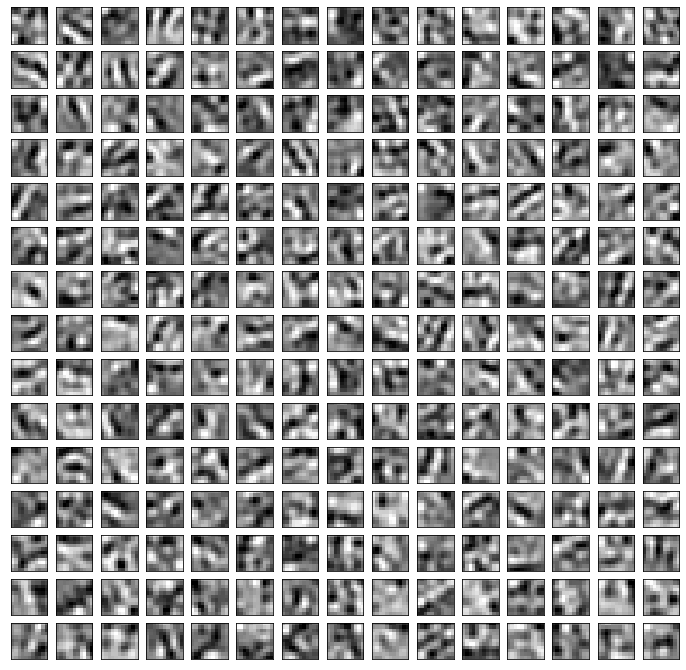

In [4]:
import re
import os

base_file = "results/gaussian_fixed_iwae/"
data_file = f"data/imagepatches_11.np"
phi_file = np.load(base_file + "train_savefile.npz")['phi']
#phi = np.load("data/mbedpatches_11.npz")['phi']

with open(data_file, 'rb') as f:
    data_patches = np.load(f)
train_idx = np.linspace(1, data_patches.shape[0] - 1, 50000, dtype=int)
train_patches = data_patches[train_idx, :, :].reshape(-1, 11**2)
train_mean, train_std = np.mean(train_patches, axis=0), np.std(train_patches, axis=0)
train_patches = (train_patches - train_mean) / train_std

with open(base_file + "config.json") as json_data:
    config_data = json.load(json_data)
train_args = SimpleNamespace(**config_data['train'])
solver_args = SimpleNamespace(**config_data['solver'])
solver_args.iwae = True
solver_args.num_samples = 20

#load_list = [int(re.search(r'epoch([0-9].*).pt', f)[1]) for f in os.listdir(base_file) if re.search(r'epoch([0-9].*).pt', f)]
#load_list = np.sort(load_list)
load_list = [0, 1, 20, 100, 200]

for idx, method in enumerate(load_list):
    np.random.seed(train_args.seed)
    torch.manual_seed(train_args.seed)

    if int(method) == 0:
        dictionary = np.random.randn(train_args.patch_size ** 2, train_args.dict_size)
        dictionary /= np.sqrt(np.sum(dictionary ** 2, axis=0))
    else:
        phi = phi_file[int(method) - 1]

    with torch.no_grad():
        encoder = VIEncoder(train_args.patch_size, train_args.dict_size, solver_args).to('cuda:1')
        encoder.load_state_dict(torch.load(base_file  + f"/encoderstate_epoch{method}.pt")['model_state'])

        code_est = np.zeros((len(train_patches), phi.shape[1]))
        
        for i in range(train_patches.shape[0] // train_args.batch_size):
            patches = train_patches[i * train_args.batch_size:(i + 1) * train_args.batch_size].T

            patches_cu = torch.tensor(patches.T).float().to('cuda:1')
            dict_cu = torch.tensor(phi, device='cuda:1').float()

            iwae_loss, recon_loss, kl_loss, b_cu = encoder(patches_cu, dict_cu)
            code_est[i * train_args.batch_size:(i + 1) * train_args.batch_size] = b_cu.detach().cpu().numpy()

        C_sr = (train_patches.T @ code_est) / len(train_patches)
        C_rr = (code_est.T @ code_est) / len(train_patches)
        recovered_dict = C_sr @ np.linalg.pinv(C_rr)

        num_dictionaries = recovered_dict.shape[1]
        patch_size = int(np.sqrt(recovered_dict.shape[0]))
        fig = plt.figure(figsize=(12, 12))
        for i in range(num_dictionaries):
            plt.subplot(int(np.sqrt(num_dictionaries)), int(np.sqrt(num_dictionaries)), i + 1)
            dict_element = recovered_dict[:, i].reshape(patch_size, patch_size)
            plt.imshow(dict_element, cmap='gray')
        plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])